## Libraries import

In [1]:
# common imports
import os
import glob
import random
import numpy as np
import pandas as pd
from scipy.stats import randint

# models libraries
from lightgbm.sklearn import LGBMRegressor
from sklearn.svm import SVR

# sklearn imports 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

# hyperopt imports to perform bayesian optimisation 
from hyperopt import Trials, anneal, fmin, hp, tpe

%matplotlib inline

## Helper functions

In [2]:
# the metric used in this competition
def comp_metric(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt(np.power(xhat - x,2) + np.power(yhat-y,2)) + 15 * np.abs(fhat-f)
    return intermediate.sum()/xhat.shape[0]

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    #torch.manual_seed(seed)
    #torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.deterministic = True

SEED = 42
seed_everything(SEED)


# cv strategy 
N_FOLDS = 5
folds = GroupKFold(n_splits=N_FOLDS)

# which optimisation to perform
perform_RandomCVSearch = False
perform_hyperoptParsenEstimator = False
perform_hyperoptSimpleAnnealing = True

# number of experiments to perform 
n_iter = 3

## Read sample data

In [3]:
feature_dir = "referencePublicNotebooks/1000Features"

# get our train and test files
train_files = sorted(glob.glob(os.path.join(feature_dir, 'train/*_train.csv')))
test_files = sorted(glob.glob(os.path.join(feature_dir, 'test/*_test.csv')))
ssubm = pd.read_csv('sample_submission.csv', index_col=0)
print(len(train_files),len(test_files))

24 24


In [4]:
# selecting a particular site and choosing y coorindate
e = 0
data = pd.read_csv(train_files[e], index_col=0)
print(data.shape)
data.head(3)

(9296, 945)


,000840e5c600de293cea57f13326f273c86c3988,00ad587dcb9c7ce3788b92e22777a22ee0efea31,00af060fc145ee6a6a50475efa57b91cbf54237f,00bcc61bdea4d52d050822d66952dd707c2fcdf3,00f0904087c01d922d6ebf3005607dfdeaf6687b,011e20ebf721a1c6dfec42e8ed1e2ac566073a2a,01d2f676abab6ec03ec5dc696bfd49d66e392ea1,01e25e4a25acd32baf5137b3031151f751fadbb4,026c2f057932da75680b21ecdbd23bf9cb9350f3,028a310e23177c3747d37971678dd964ee28ce17,...,fdc189e5a19850397f37201f4acc378cfddcf0d6,fdc19f011587b75c11a6c30d8ca06d90107b6bde,fdf37fa13679f581bdfaae3b99e368633e0a144b,fdfe926caf5f49a88a9bcab8d025e887f422128b,fe3211f90e4ab1f500e10fe175ae6142f4b13130,ffa41c79865d7fb336f586e0dec8b080db1027fb,x,y,f,path
4,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,155.65668,89.40598,-1,5e158edff4c3420006d52172
4,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,155.65668,89.40598,-1,5e158edff4c3420006d52172
4,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,154.68399,81.80792,-1,5e158edff4c3420006d52172


## Prepare model inputs and outputs

In [5]:
x_train = data.iloc[:,:-4].values.astype(int)
y_trainy = data.iloc[:,-3].values.astype(float)
y_trainx = data.iloc[:,-4].values.astype(float)
y_trainf = data.iloc[:,-2].values.astype(float)
groups = data["path"]

In [6]:
# normlise inputs
stdScaler = StandardScaler()
x_train = stdScaler.fit_transform(x_train)

## Baseline Lightgbm and SVR model 

In [7]:
%%time

# baseline lightgbm model
model = LGBMRegressor(n_estimators=125, num_leaves=90, random_state=SEED)
results = -cross_val_score(model, X=x_train, y=y_trainy, groups=groups, 
                              scoring="neg_mean_squared_error", cv=folds, n_jobs=-1)
print(f"Cross val score for y coordinate is {results.mean()}")
print(results)

Cross val score for y coordinate is 77.47947111520742
[90.20551365 92.8808168  53.35521555 68.3332076  82.62260198]
CPU times: user 60.7 ms, sys: 69 ms, total: 130 ms
Wall time: 16.7 s


In [8]:
%%time

# baseline svm model
# svrModel = SVR(C=100.0, epsilon=0.01)
# results = -cross_val_score(svrModel, X=x_train, y=y_trainy, groups=groups, 
#                              scoring="neg_mean_squared_error", cv=folds, n_jobs=-1)
# print(f"Cross val score for y coordinate is {results.mean()}")
# print(results)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


## Randomized grid search

In [10]:
%%time
if perform_RandomCVSearch == True:

    param_grid_rand = {
    "learning_rate": np.logspace(-5, 0, 100),
    "max_depth": randint(2, 20),
    "n_estimators": randint(100, 2000),
    "random_state": [SEED],
    }
    
    rs = RandomizedSearchCV(model,
        param_grid_rand,
        n_iter=n_iter,
        scoring="neg_mean_squared_error",
        #fit_params=None,
        n_jobs=-1,
        cv=folds,
        verbose=True,
        random_state=SEED,
    )

    rs.fit(x_train, y_trainy, groups=groups)
    print("Best MSE {:.3f} params {}".format(-rs.best_score_, rs.best_params_))

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 9.54 µs


In [11]:
if perform_RandomCVSearch == True:
    rs_results_df = pd.DataFrame(
        np.transpose(
            [
                -rs.cv_results_["mean_test_score"],
                rs.cv_results_["param_learning_rate"].data,
                rs.cv_results_["param_max_depth"].data,
                rs.cv_results_["param_n_estimators"].data,
            ]
        ),
        columns=["score", "learning_rate", "max_depth", "n_estimators"],
    )
    rs_results_df.plot(subplots=True, figsize=(10, 10))

## Hyperopt method 1 - Tree-structured Parzen Estimator

In [12]:
def gb_mse_cv(params, X=x_train, y=y_trainy, cv=folds,random_state=SEED):
    # the function gest a set of variable parameters in "param"
    params = {
        "n_estimators": int(params["n_estimators"]),
        "max_depth": int(params["max_depth"]),
        "learning_rate": params["learning_rate"],
        "objective": "regression",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        
    }

    # we use this params to create a new LGBM Regressor
    model = LGBMRegressor(random_state=SEED, **params)

    # and then conduct the cross validation with the same folds as before
    score = -cross_val_score(model, X=X, y=y, groups=groups, scoring="neg_mean_squared_error",
                             cv=folds, n_jobs=-1).mean()
    return score

In [13]:
%%time
if perform_hyperoptParsenEstimator == True:

    # possible values of parameters
    space = {
        "n_estimators": hp.quniform("n_estimators", 100, 2000, 1),
        "max_depth": hp.quniform("max_depth", 2, 20, 1),
        "learning_rate": hp.loguniform("learning_rate", -5, 0),
    }
    
    # trials will contain logging information
    trials = Trials()

    best = fmin(
        fn=gb_mse_cv,                       # function to optimize
        space=space,                        # search space
        algo=tpe.suggest,                   # optimization algorithm, hyperotp will select its parameters automatically
        max_evals=n_iter,                   # maximum number of iterations
        trials=trials,                      # logging
        show_progressbar=True,
        rstate=np.random.RandomState(SEED), # fixing random state for the reproducibility
    )

    print("Best MSE {:.3f} params {}".format(gb_mse_cv(best), best))

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 6.91 µs


In [14]:
if perform_hyperoptParsenEstimator == True:
    tpe_results = np.array(
        [
            [
                x["result"]["loss"],
                x["misc"]["vals"]["learning_rate"][0],
                x["misc"]["vals"]["max_depth"][0],
                x["misc"]["vals"]["n_estimators"][0],
            ]
            for x in trials.trials
        ]
    )

    tpe_results_df = pd.DataFrame(
        tpe_results, columns=["score", "learning_rate", "max_depth", "n_estimators"]
    )
    tpe_results_df.plot(subplots=True, figsize=(10, 10))

## Hyperopt method2 - Simulated annealing

In [15]:
%%time

if perform_hyperoptSimpleAnnealing == True:
    
    # possible values of parameters
    space = {
        "n_estimators": hp.quniform("n_estimators", 100, 2000, 1),
        "max_depth": hp.quniform("max_depth", 2, 20, 1),
        "learning_rate": hp.loguniform("learning_rate", -5, 0),
    }

    # trials will contain logging information
    trials = Trials()


    best = fmin(
        fn=gb_mse_cv,                       # function to optimize
        space=space,                        # search space
        algo=anneal.suggest,                # optimization algorithm, hyperotp will select its parameters automatically
        max_evals=n_iter,                   # maximum number of iterations
        trials=trials,                      # logging
        rstate=np.random.RandomState(SEED), # fixing random state for the reproducibility
        show_progressbar=True
        )

    print("Best MSE {:.3f} params {}".format(gb_mse_cv(best), best))

100%|██████████| 3/3 [01:59<00:00, 39.71s/trial, best loss: 73.05802027468181]
Best MSE 73.058 params {'learning_rate': 0.03052751366689494, 'max_depth': 7.0, 'n_estimators': 736.0}
CPU times: user 141 ms, sys: 123 ms, total: 264 ms
Wall time: 2min 26s


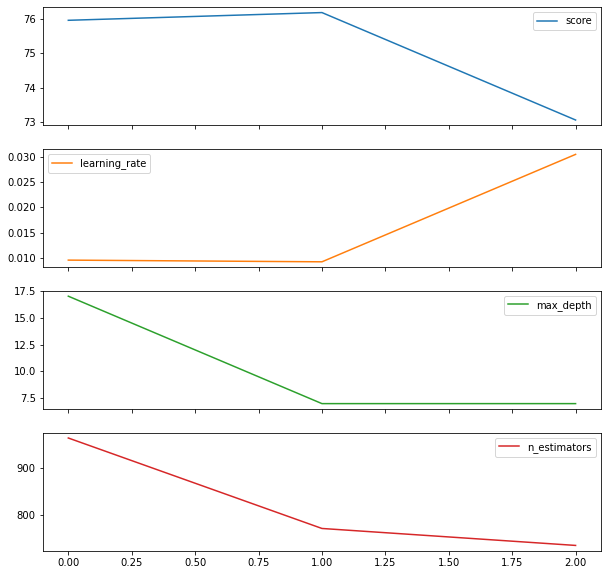

In [16]:
if perform_hyperoptSimpleAnnealing == True:
    sa_results = np.array(
        [
            [
                x["result"]["loss"],
                x["misc"]["vals"]["learning_rate"][0],
                x["misc"]["vals"]["max_depth"][0],
                x["misc"]["vals"]["n_estimators"][0],
            ]
            for x in trials.trials
        ]
    )

    sa_results_df = pd.DataFrame(
        sa_results, columns=["score", "learning_rate", "max_depth", "n_estimators"]
    )
    sa_results_df.plot(subplots=True, figsize=(10, 10))